# Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed for this project.

In [1]:
import os
import random
import shutil
from typing import Tuple, Optional, List, Dict, Any
from datetime import datetime

# PyTorch 相关
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

# 数据处理和科学计算
import numpy as np
import pandas as pd

# 图像处理 (不使用 SimpleITK)
import nibabel as nib
import cv2

# 可视化
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 进度条和日志
from tqdm import tqdm
import logging

# 设置随机种子以确保可复现性
def set_seed(seed: int = 42) -> None:
    """设置全局随机种子"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("brain_tumor_segmentation.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# 输出环境信息
logger.info(f"Using device: {device}")
logger.info(f"PyTorch version: {torch.__version__}")
logger.info(f"NumPy version: {np.__version__}")
logger.info(f"OpenCV version: {cv2.__version__}")

# 创建必要的目录
def create_directories(dirs: List[str]) -> None:
    """创建必要的目录"""
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)
        logger.debug(f"Created directory: {dir_path}")

# 清理并重新创建目录
def reset_directories(base_dirs: List[str]) -> None:
    """删除旧目录并重新创建"""
    for d in base_dirs:
        if os.path.exists(d):
            shutil.rmtree(d)
            logger.debug(f"Removed directory: {d}")
        os.makedirs(d, exist_ok=True)
        logger.debug(f"Created directory: {d}")

set_seed(42)  # 设置随机种子

2025-08-12 18:42:58,705 - INFO - Using device: cuda
2025-08-12 18:42:58,707 - INFO - PyTorch version: 2.7.0+cu118
2025-08-12 18:42:58,708 - INFO - NumPy version: 2.2.6
2025-08-12 18:42:58,709 - INFO - OpenCV version: 4.12.0


## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which are like pixels in 2D images. Here, try to visualise the axial plane (which usually has higher resolution) of some of the volumes and the corresponding segmentation maps.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from typing import Optional, Tuple, List
import cv2
import logging

logger = logging.getLogger(__name__)

# 定义肿瘤类别颜色映射
CLASS_COLORS = {
    'background': (0, 0, 0),      # 黑色 - 背景区域
    'edema': (0, 0, 255),         # 蓝色 - 水肿区域
    'non-enhancing': (0, 255, 0), # 绿色 - 非增强肿瘤区域
    'enhancing': (255, 0, 0)      # 红色 - 增强肿瘤区域
}

def load_nifti(filepath: str) -> np.ndarray:
    """
    加载 NIfTI 格式的图像文件
    
    Args:
        filepath (str): NIfTI 文件路径
        
    Returns:
        np.ndarray: 图像数据数组
    """
    try:
        image = nib.load(filepath)
        data = image.get_fdata()
        logger.debug(f"Loaded image from {filepath}, shape: {data.shape}")
        return data
    except Exception as e:
        logger.error(f"Failed to load image from {filepath}: {e}")
        raise


In [3]:
def normalize_image(image: np.ndarray, percentile: Tuple[float, float] = (1, 99)) -> np.ndarray:
    """
    使用百分位数归一化图像强度
    
    Args:
        image (np.ndarray): 输入图像
        percentile (Tuple[float, float]): 百分位数范围，默认(1, 99)
        
    Returns:
        np.ndarray: 归一化后的图像
    """
    # 去除零值（背景）
    non_zero_voxels = image[image > 0]
    if len(non_zero_voxels) == 0:
        return image
    
    # 计算百分位数
    lower, upper = np.percentile(non_zero_voxels, percentile)
    
    # 截断并归一化到[0, 1]
    image = np.clip(image, lower, upper)
    if upper > lower:
        image = (image - lower) / (upper - lower)
    return image

def show_mri_volume_slices_for_segmentation(
    mri_path: str, 
    mask_path: str,
    case_id: str,
    slice_indices: Optional[List[int]] = None,
    num_slices: int = 6,
    slice_axis: int = 2,  # 0: Sagittal, 1: Coronal, 2: Axial
    figsize: Tuple[int, int] = (15, 10)
) -> None:
    """
    为分割任务可视化MRI体积的多个切片及其对应的分割掩码
    
    Args:
        mri_path (str): MRI图像文件路径 (e.g., '001_fla.nii.gz')
        mask_path (str): 分割掩码文件路径 (e.g., '001_seg.nii.gz')
        case_id (str): 病例ID (e.g., '001')
        slice_indices (Optional[List[int]]): 指定要显示的切片索引
        num_slices (int): 要显示的切片数量（如果slice_indices未指定）
        slice_axis (int): 切片轴向 (0: Sagittal, 1: Coronal, 2: Axial)
        figsize (Tuple[int, int]): 图像大小
    """
    # 加载MRI数据
    mri_data = load_nifti(mri_path)
    
    # 加载掩码数据
    mask_data = load_nifti(mask_path)
    
    # 检查MRI和掩码尺寸是否匹配
    if mri_data.shape != mask_data.shape:
        logger.warning(f"MRI shape {mri_data.shape} does not match mask shape {mask_data.shape}")
        # 尝试调整掩码尺寸以匹配MRI
        # 注意：这里是一个简化的处理，实际应用中可能需要更复杂的重采样
        if len(mask_data.shape) == 3 and len(mri_data.shape) == 3:
            # 简单的重采样（仅作为示例，实际应用中建议使用专业库）
            from scipy.ndimage import zoom
            zoom_factors = [mri_dim / mask_dim for mri_dim, mask_dim in zip(mri_data.shape, mask_data.shape)]
            mask_data = zoom(mask_data, zoom_factors, order=0)  # order=0 表示最近邻插值
    
    # 确定要显示的切片索引
    if slice_indices is None:
        total_slices = mri_data.shape[slice_axis]
        # 选择均匀分布的切片
        slice_indices = np.linspace(0, total_slices - 1, num_slices, dtype=int)
    
    # 创建子图
    fig, axes = plt.subplots(len(slice_indices), 2, figsize=figsize)
    if len(slice_indices) == 1:
        axes = axes[np.newaxis, :]
    elif len(slice_indices) == 0:
        logger.error("No slices to display")
        return
    
    # 获取图像轴向名称
    axis_names = ['Sagittal', 'Coronal', 'Axial']
    axis_name = axis_names[slice_axis]
    
    # 创建图例
    legend_elements = [Patch(facecolor=np.array(color)/255.0, label=cls_name) 
                      for cls_name, color in CLASS_COLORS.items() if cls_name != 'background']
    
    for i, slice_idx in enumerate(slice_indices):
        # 提取切片
        if slice_axis == 0:
            mri_slice = mri_data[slice_idx, :, :]
            mask_slice = mask_data[slice_idx, :, :]
        elif slice_axis == 1:
            mri_slice = mri_data[:, slice_idx, :]
            mask_slice = mask_data[:, slice_idx, :]
        else:  # slice_axis == 2 (Axial)
            mri_slice = mri_data[:, :, slice_idx]
            mask_slice = mask_data[:, :, slice_idx]
        
        # 归一化MRI切片
        mri_slice_norm = normalize_image(mri_slice)
        
        # 显示MRI切片
        ax_mri = axes[i, 0]
        ax_mri.imshow(mri_slice_norm.T, cmap='gray', origin='lower')
        ax_mri.set_title(f'Case {case_id} - {axis_name} Slice {slice_idx}')
        ax_mri.axis('off')
        
        # 显示叠加图
        ax_mask = axes[i, 1]
        ax_mask.imshow(mri_slice_norm.T, cmap='gray', origin='lower')
        
        # 创建彩色掩码叠加
        # 假设掩码值含义：0=背景, 1=水肿, 2=非增强肿瘤, 3=增强肿瘤
        mask_overlay = np.zeros((*mask_slice.shape, 3))
        for class_value in range(1, 4):  # 1, 2, 3
            color = list(CLASS_COLORS.values())[class_value]
            mask_overlay[mask_slice == class_value] = np.array(color) / 255.0
        
        ax_mask.imshow(mask_overlay.transpose(1, 0, 2), alpha=0.5, origin='lower')
        ax_mask.set_title(f'Case {case_id} - {axis_name} Slice {slice_idx} with Mask')
        ax_mask.axis('off')
    
    # 添加图例
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4)
    
    plt.tight_layout()
    plt.show()

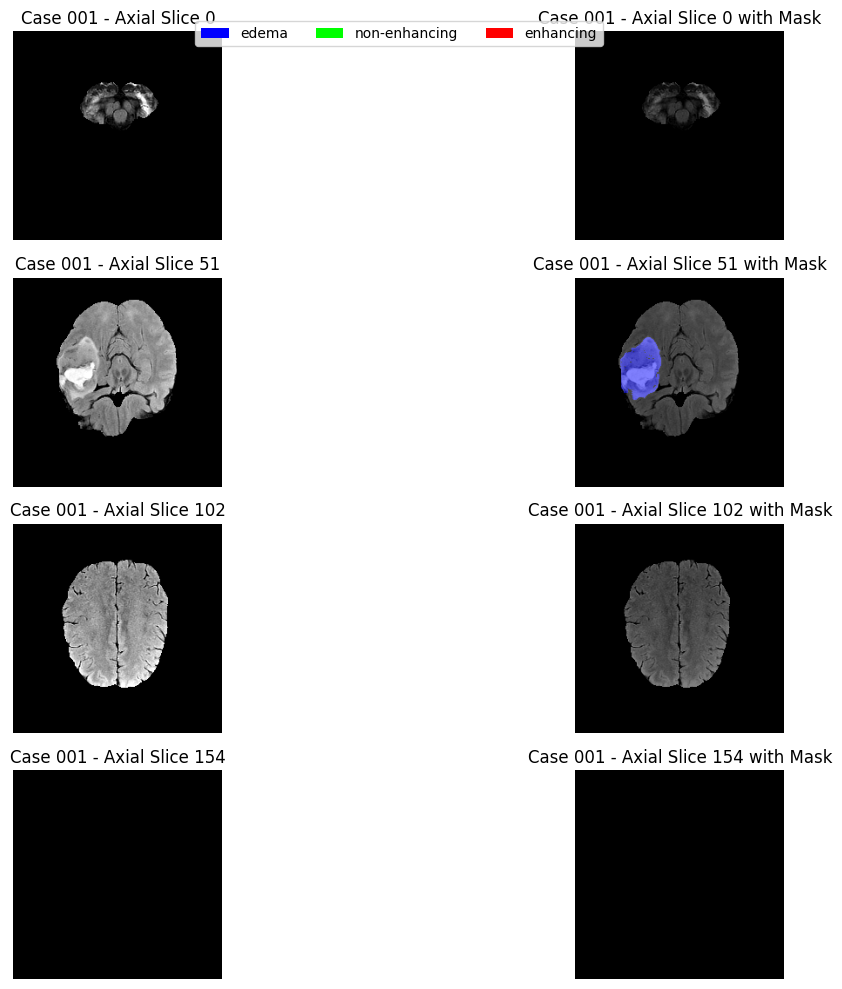

In [4]:
dataset_path = 'dataset_segmentation/train'
case_id = '001'
mri_file = os.path.join(dataset_path, case_id, f"{case_id}_fla.nii.gz")
mask_file = os.path.join(dataset_path, case_id, f"{case_id}_seg.nii.gz")

show_mri_volume_slices_for_segmentation(
    mri_path=mri_file,
    mask_path=mask_file,
    case_id=case_id,
    num_slices=4,
    slice_axis=2  # Axial slices
)

## Data preprocessing (Optional)

Images in the original dataset are usually of different sizes, so sometimes we need to resize and normalise them (z-score is commonly used in preprocessing MRI images) to fit the CNN model. Depending on the images you choose to use for training your model, you may need to apply other preprocessing methods. If preprocessing methods like cropping are applied, remember to convert the segmentation result back to its original size.

In [5]:
def resize_image(image: np.ndarray, target_size: Tuple[int, int] = (240, 240)) -> np.ndarray:
    """
    重采样2D图像到目标尺寸
    
    Args:
        image (np.ndarray): 输入2D图像
        target_size (Tuple[int, int]): 目标尺寸 (height, width)
        
    Returns:
        np.ndarray: 重采样后的图像
    """
    if len(image.shape) != 2:
        raise ValueError("Input image must be 2D")
    
    # 使用双线性插值重采样
    resampled = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    return resampled

def resize_3d_volume(volume: np.ndarray, target_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    重采样3D体积到目标形状
    
    Args:
        volume (np.ndarray): 输入3D体积
        target_shape (Tuple[int, int, int]): 目标形状 (depth, height, width)
        
    Returns:
        np.ndarray: 重采样后的3D体积
    """
    from scipy.ndimage import zoom
    
    if len(volume.shape) != 3:
        raise ValueError("Input volume must be 3D")
    
    # 计算缩放因子
    zoom_factors = [target_dim / original_dim for target_dim, original_dim in zip(target_shape, volume.shape)]
    
    # 使用最近邻插值重采样（适用于分割掩码）
    resampled = zoom(volume, zoom_factors, order=0)  # order=0 for nearest neighbor
    return resampled

def z_score_normalize(image: np.ndarray) -> np.ndarray:
    """
    Z-score标准化（零均值单位方差）
    
    Args:
        image (np.ndarray): 输入图像
        
    Returns:
        np.ndarray: 标准化后的图像
    """
    # 只对非零像素进行标准化（忽略背景）
    mask = image > 0
    if np.sum(mask) > 0:
        mean = np.mean(image[mask])
        std = np.std(image[mask])
        if std > 0:
            normalized = np.zeros_like(image, dtype=np.float32)
            normalized[mask] = (image[mask] - mean) / std
            return normalized
    return image.astype(np.float32)

def min_max_normalize(image: np.ndarray) -> np.ndarray:
    """
    Min-Max标准化到[0, 1]范围
    
    Args:
        image (np.ndarray): 输入图像
        
    Returns:
        np.ndarray: 标准化后的图像
    """
    # 只对非零像素进行标准化（忽略背景）
    mask = image > 0
    if np.sum(mask) > 0:
        min_val = np.min(image[mask])
        max_val = np.max(image[mask])
        if max_val > min_val:
            normalized = np.zeros_like(image, dtype=np.float32)
            normalized[mask] = (image[mask] - min_val) / (max_val - min_val)
            return normalized
    return image.astype(np.float32)

def preprocess_mri_slice(
    mri_slice: np.ndarray, 
    target_size: Tuple[int, int] = (240, 240),
    normalize_method: str = 'z_score'  # 'z_score' or 'min_max'
) -> np.ndarray:
    """
    预处理单个MRI切片：调整大小并标准化
    
    Args:
        mri_slice (np.ndarray): 输入MRI切片
        target_size (Tuple[int, int]): 目标尺寸
        normalize_method (str): 标准化方法
        
    Returns:
        np.ndarray: 预处理后的MRI切片
    """
    # 1. 调整大小
    resized = resize_image(mri_slice, target_size)
    
    # 2. 标准化
    if normalize_method == 'z_score':
        normalized = z_score_normalize(resized)
    elif normalize_method == 'min_max':
        normalized = min_max_normalize(resized)
    else:
        raise ValueError(f"Unknown normalize_method: {normalize_method}")
    
    return normalized

def preprocess_segmentation_mask(
    mask_slice: np.ndarray, 
    target_size: Tuple[int, int] = (240, 240)
) -> np.ndarray:
    """
    预处理分割掩码：调整大小（使用最近邻插值以保持类别标签）
    
    Args:
        mask_slice (np.ndarray): 输入分割掩码
        target_size (Tuple[int, int]): 目标尺寸
        
    Returns:
        np.ndarray: 预处理后的分割掩码
    """
    # 调整大小（使用最近邻插值以保持整数标签）
    resized = cv2.resize(mask_slice, target_size, interpolation=cv2.INTER_NEAREST)
    return resized

## Train-time data augmentation
Generalizability is crucial to a deep learning model, and it refers to the performance difference of a model when evaluated on seen data (training data) versus unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimize the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose from in this project, including rotation, shifting, flipping, etc. PyTorch provides excellent data augmentation capabilities through torchvision.transforms, which you can combine with custom transforms for medical imaging.

You are encouraged to try different augmentation methods to get the best segmentation result.


## Get the data generator ready

In [6]:
class BrainTumorSegmentationDataset(Dataset):
    """脑肿瘤分割数据集类"""
    
    def __init__(
        self, 
        data_list: List[Tuple[str, str]],  # [(mri_path, mask_path), ...]
        transform: Optional[transforms.Compose] = None,
        augment: bool = False,
        target_size: Tuple[int, int] = (240, 240)
    ):
        """
        初始化数据集
        
        Args:
            data_list: 包含MRI和掩码路径的元组列表
            transform: 基础变换
            augment: 是否应用数据增强
            target_size: 目标图像尺寸
        """
        self.data_list = data_list
        self.transform = transform
        self.augment = augment
        self.target_size = target_size
        
    def __len__(self) -> int:
        return len(self.data_list)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # 获取MRI和掩码路径
        mri_path, mask_path = self.data_list[idx]
        
        # 加载数据
        mri_data = load_nifti(mri_path)
        mask_data = load_nifti(mask_path)
        
        # 选择一个轴向切片（这里选择轴向中间切片）
        slice_idx = mri_data.shape[2] // 2
        mri_slice = mri_data[:, :, slice_idx]
        mask_slice = mask_data[:, :, slice_idx]
        
        # 预处理
        mri_slice = preprocess_mri_slice(mri_slice, self.target_size, normalize_method='z_score')
        mask_slice = preprocess_segmentation_mask(mask_slice, self.target_size)
        
        # 转换为PyTorch张量
        mri_tensor = torch.from_numpy(mri_slice).float().unsqueeze(0)  # 添加通道维度 [1, H, W]
        mask_tensor = torch.from_numpy(mask_slice).long()  # 分割标签应为long类型 [H, W]
        
        # 如果是3通道模型输入，可以复制通道
        # mri_tensor = mri_tensor.repeat(3, 1, 1)  # [3, H, W]
        
        # 应用数据增强（仅对训练集）
        if self.augment:
            mri_tensor, mask_tensor = self._apply_augmentation(mri_tensor, mask_tensor)
        
        # 应用基础变换
        if self.transform:
            mri_tensor = self.transform(mri_tensor)
            
        return mri_tensor, mask_tensor
    
    def _apply_augmentation(self, mri_tensor: torch.Tensor, mask_tensor: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        应用数据增强
        
        Args:
            mri_tensor: MRI图像张量
            mask_tensor: 掩码张量
            
        Returns:
            增强后的张量
        """
        import torchvision.transforms.functional as F
        
        # 随机水平翻转
        if random.random() > 0.5:
            mri_tensor = F.hflip(mri_tensor)
            mask_tensor = F.hflip(mask_tensor)
        
        # 随机垂直翻转
        if random.random() > 0.5:
            mri_tensor = F.vflip(mri_tensor)
            mask_tensor = F.vflip(mask_tensor)
        
        # 随机旋转（-15到15度）
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            mri_tensor = F.rotate(mri_tensor, angle, fill=0)
            # 注意：对于掩码，应该使用最近邻插值
            mask_tensor = F.rotate(mask_tensor.unsqueeze(0), angle, interpolation=F.InterpolationMode.NEAREST, fill=0).squeeze(0)
        
        return mri_tensor, mask_tensor

def get_data_generators(
    train_data_list: List[Tuple[str, str]],
    val_data_list: List[Tuple[str, str]],
    batch_size: int = 16,
    num_workers: int = 4,
    target_size: Tuple[int, int] = (240, 240)
) -> Tuple[DataLoader, DataLoader]:
    """
    获取训练和验证数据生成器（DataLoader）
    
    Args:
        train_data_list: 训练数据路径列表
        val_data_list: 验证数据路径列表
        batch_size: 批次大小
        num_workers: 数据加载工作进程数
        target_size: 目标图像尺寸
        
    Returns:
        (train_loader, val_loader): 训练和验证数据加载器
    """
    
    # 定义基础变换
    base_transform = transforms.Compose([
        transforms.Normalize(mean=[0.0], std=[1.0])  # MRI数据通常已经标准化，这里可以是空操作或微调
    ])
    
    # 创建训练数据集（带增强）
    train_dataset = BrainTumorSegmentationDataset(
        data_list=train_data_list,
        transform=base_transform,
        augment=True,
        target_size=target_size
    )
    
    # 创建验证数据集（不带增强）
    val_dataset = BrainTumorSegmentationDataset(
        data_list=val_data_list,
        transform=base_transform,
        augment=False,
        target_size=target_size
    )
    
    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    logger.info(f"Train dataset size: {len(train_dataset)}")
    logger.info(f"Validation dataset size: {len(val_dataset)}")
    logger.info(f"Train batches: {len(train_loader)}")
    logger.info(f"Validation batches: {len(val_loader)}")
    
    return train_loader, val_loader

## Define a metric for the performance of the model
The Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. The Dice score can also be used as the loss function for training your model.

In [7]:
def dice_coefficient(
    pred: torch.Tensor, 
    target: torch.Tensor, 
    smooth: float = 1e-6,
    num_classes: int = 4  # 0: background, 1: edema, 2: non-enhancing, 3: enhancing
) -> torch.Tensor:
    """
    计算多类别的Dice系数
    
    Args:
        pred (torch.Tensor): 模型预测结果 (N, C, H, W) 或 (N, H, W)
        target (torch.Tensor): 真实标签 (N, H, W)
        smooth (float): 平滑项，防止除零错误
        num_classes (int): 类别数量
        
    Returns:
        torch.Tensor: 平均Dice系数 (标量)
    """
    # 如果预测结果是 logits (N, C, H, W)，需要先转换为类别预测
    if pred.dim() == 4 and pred.shape[1] == num_classes:
        pred = torch.argmax(pred, dim=1)  # (N, H, W)
    
    # 确保pred和target的维度一致
    assert pred.shape == target.shape, f"Pred shape {pred.shape} != Target shape {target.shape}"
    
    dice_scores = []
    
    # 计算每个类别的Dice系数
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = torch.sum(pred_class * target_class)
        pred_sum = torch.sum(pred_class)
        target_sum = torch.sum(target_class)
        
        dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)
        dice_scores.append(dice)
    
    # 返回所有类别的平均Dice系数
    return torch.mean(torch.stack(dice_scores))

def dice_loss(
    pred: torch.Tensor, 
    target: torch.Tensor, 
    smooth: float = 1e-6,
    num_classes: int = 4
) -> torch.Tensor:
    """
    Dice Loss，可以用作训练损失函数
    
    Args:
        pred (torch.Tensor): 模型预测结果 (N, C, H, W)
        target (torch.Tensor): 真实标签 (N, H, W)
        smooth (float): 平滑项
        num_classes (int): 类别数量
        
    Returns:
        torch.Tensor: Dice Loss (标量)
    """
    # 使用Dice系数计算Dice Loss
    dice_score = dice_coefficient(pred, target, smooth, num_classes)
    return 1 - dice_score

def per_class_dice_coefficient(
    pred: torch.Tensor, 
    target: torch.Tensor, 
    smooth: float = 1e-6,
    class_names: Optional[list] = None
) -> dict:
    """
    计算每个类别的Dice系数
    
    Args:
        pred (torch.Tensor): 模型预测结果 (N, C, H, W) 或 (N, H, W)
        target (torch.Tensor): 真实标签 (N, H, W)
        smooth (float): 平滑项
        class_names (list): 类别名称列表
        
    Returns:
        dict: 包含每个类别Dice系数的字典
    """
    num_classes = 4  # 根据你的数据集调整
    
    if class_names is None:
        class_names = ['background', 'edema', 'non-enhancing', 'enhancing']
    
    # 如果预测结果是 logits (N, C, H, W)，需要先转换为类别预测
    if pred.dim() == 4 and pred.shape[1] == num_classes:
        pred = torch.argmax(pred, dim=1)  # (N, H, W)
    
    dice_scores = {}
    
    # 计算每个类别的Dice系数
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = torch.sum(pred_class * target_class)
        pred_sum = torch.sum(pred_class)
        target_sum = torch.sum(target_class)
        
        dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)
        dice_scores[class_names[class_idx]] = dice.item()
    
    return dice_scores

def train_epoch_with_dice(model, train_loader, criterion, optimizer, device, num_classes=4):
    """
    使用Dice系数作为评价指标的训练epoch函数
    """
    model.train()
    running_loss = 0.0
    total_dice = 0.0
    num_batches = 0
    
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)  # 可以是交叉熵损失或其他损失
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算Dice系数
            with torch.no_grad():
                dice_score = dice_coefficient(outputs, targets, num_classes=num_classes)
                total_dice += dice_score.item()
            
            num_batches += 1
            
            # 更新进度条
            pbar.set_postfix({
                'loss': loss.item(), 
                'dice': dice_score.item()
            })
            pbar.update(1)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_dice = total_dice / num_batches
    return epoch_loss, epoch_dice

def validate_epoch_with_dice(model, val_loader, criterion, device, num_classes=4):
    """
    使用Dice系数作为评价指标的验证epoch函数
    """
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    num_batches = 0
    
    with tqdm(total=len(val_loader), desc="Validating", unit="batch") as pbar:
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item()
                
                # 计算Dice系数
                dice_score = dice_coefficient(outputs, targets, num_classes=num_classes)
                total_dice += dice_score.item()
                
                num_batches += 1
                
                # 更新进度条
                pbar.set_postfix({
                    'loss': loss.item(), 
                    'dice': dice_score.item()
                })
                pbar.update(1)
    
    epoch_loss = running_loss / len(val_loader)
    epoch_dice = total_dice / num_batches
    return epoch_loss, epoch_dice

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for medical image segmentation tasks. You can build your own model or modify the U-Net by changing the hyperparameters for our task. If you choose to use PyTorch, more information about PyTorch layers, including Conv2d, MaxPool2d, and Dropout, can be found at https://pytorch.org/docs/stable/nn.html. You can also explore popular PyTorch implementations of U-Net for medical image segmentation.

In [8]:
class DoubleConv(nn.Module):
    """U-Net中的双重卷积块"""
    
    def __init__(self, in_channels: int, out_channels: int, dropout_rate: float = 0.0):
        """
        初始化双重卷积块
        
        Args:
            in_channels (int): 输入通道数
            out_channels (int): 输出通道数
            dropout_rate (float): Dropout比率
        """
        super(DoubleConv, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))
            
        self.double_conv = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)


class Down(nn.Module):
    """U-Net中的下采样模块"""
    
    def __init__(self, in_channels: int, out_channels: int, dropout_rate: float = 0.0):
        """
        初始化下采样模块
        
        Args:
            in_channels (int): 输入通道数
            out_channels (int): 输出通道数
            dropout_rate (float): Dropout比率
        """
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)


class Up(nn.Module):
    """U-Net中的上采样模块"""
    
    def __init__(self, in_channels: int, out_channels: int, dropout_rate: float = 0.0):
        """
        初始化上采样模块
        
        Args:
            in_channels (int): 输入通道数
            out_channels (int): 输出通道数
            dropout_rate (float): Dropout比率
        """
        super(Up, self).__init__()
        
        # 使用转置卷积进行上采样
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, dropout_rate)
    
    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        # 上采样
        x1 = self.up(x1)
        
        # 处理尺寸不匹配的情况
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # 跳跃连接：拼接特征图
        x = torch.cat([x2, x1], dim=1)
        
        # 双重卷积
        return self.conv(x)


class OutConv(nn.Module):
    """U-Net中的输出卷积层"""
    
    def __init__(self, in_channels: int, out_channels: int):
        """
        初始化输出卷积层
        
        Args:
            in_channels (int): 输入通道数
            out_channels (int): 输出通道数（等于类别数）
        """
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class UNet(nn.Module):
    """为脑肿瘤分割任务优化的U-Net模型"""
    
    def __init__(
        self,
        n_channels: int = 1,  # MRI图像通常是单通道
        n_classes: int = 4,   # 4个类别：背景, 水肿, 非增强肿瘤, 增强肿瘤
        dropout_rate: float = 0.1  # Dropout比率
    ):
        """
        初始化U-Net模型
        
        Args:
            n_channels (int): 输入图像通道数
            n_classes (int): 输出类别数
            dropout_rate (float): Dropout比率
        """
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # 编码器路径 (Encoder Path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128, dropout_rate)
        self.down2 = Down(128, 256, dropout_rate)
        self.down3 = Down(256, 512, dropout_rate)
        self.down4 = Down(512, 1024, dropout_rate)
        
        # 解码器路径 (Decoder Path)
        self.up1 = Up(1024, 512, dropout_rate)
        self.up2 = Up(512, 256, dropout_rate)
        self.up3 = Up(256, 128, dropout_rate)
        self.up4 = Up(128, 64, dropout_rate)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 编码器
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # 解码器与跳跃连接
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits


# 创建模型实例的函数
def create_model(
    n_channels: int = 1,
    n_classes: int = 4,
    dropout_rate: float = 0.1
) -> UNet:
    """
    创建U-Net模型实例
    
    Args:
        n_channels: 输入通道数
        n_classes: 输出类别数
        dropout_rate: Dropout比率
        
    Returns:
        UNet: 模型实例
    """
    return UNet(n_channels=n_channels, n_classes=n_classes, dropout_rate=dropout_rate)


# 模型信息打印函数
def print_model_info(model: nn.Module, input_shape: tuple = (1, 1, 240, 240)):
    """
    打印模型信息
    
    Args:
        model: PyTorch模型
        input_shape: 输入张量形状 (batch, channels, height, width)
    """
    # 计算参数数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # 测试前向传播
    try:
        device = next(model.parameters()).device
        dummy_input = torch.randn(input_shape).to(device)
        with torch.no_grad():
            output = model(dummy_input)
        print(f"Input shape: {input_shape}")
        print(f"Output shape: {output.shape}")
        print("Model test passed!")
    except Exception as e:
        print(f"Model test failed: {e}")

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 创建模型实例
model = create_model(n_channels=1, n_classes=4, dropout_rate=0.1)
model = model.to(device)

# 打印模型信息
print_model_info(model)

Using device: cuda
Model: UNet
Total parameters: 31,042,564
Trainable parameters: 31,042,564
Input shape: (1, 1, 240, 240)
Output shape: torch.Size([1, 4, 240, 240])
Model test passed!


## Train your model here
Once you have defined the model and data generator, you can start training your model. In PyTorch, you'll need to set up the training loop with the optimizer, loss function, and implement forward and backward passes manually.

In [10]:
from torch.cuda.amp import GradScaler, autocast
logger = logging.getLogger(__name__)

# 损失函数定义
def dice_loss(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1e-6) -> torch.Tensor:
    """
    Dice Loss，用于训练
    """
    # 将预测结果转换为概率（如果是logits）
    if pred.shape[1] > 1:
        pred = torch.softmax(pred, dim=1)
    
    # 确保target是one-hot编码
    if target.dim() == 3:  # (B, H, W)
        target_one_hot = torch.zeros_like(pred)  # (B, C, H, W)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)
        target = target_one_hot
    
    # 计算Dice系数
    intersection = torch.sum(pred * target, dim=(0, 2, 3))
    pred_sum = torch.sum(pred, dim=(0, 2, 3))
    target_sum = torch.sum(target, dim=(0, 2, 3))
    
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)
    
    # 返回Dice Loss (1 - 平均Dice系数)
    return 1 - torch.mean(dice)

def combined_loss(pred: torch.Tensor, target: torch.Tensor, ce_weight: float = 0.5, dice_weight: float = 0.5) -> torch.Tensor:
    """
    结合交叉熵损失和Dice损失的组合损失函数
    """
    # 交叉熵损失
    ce_loss = nn.CrossEntropyLoss()(pred, target)
    
    # Dice损失
    dice_loss_val = dice_loss(pred, target)
    
    # 组合损失
    return ce_weight * ce_loss + dice_weight * dice_loss_val

def dice_coefficient(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1e-6) -> float:
    """
    计算Dice系数用于评估
    """
    # 将预测结果转换为类别
    if pred.shape[1] > 1:
        pred = torch.argmax(pred, dim=1)
    
    # 计算每个类别的Dice系数
    dice_scores = []
    num_classes = 4  # 根据你的数据集调整
    
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = torch.sum(pred_class * target_class)
        pred_sum = torch.sum(pred_class)
        target_sum = torch.sum(target_class)
        
        dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)
        dice_scores.append(dice.item())
    
    # 返回平均Dice系数
    return sum(dice_scores) / len(dice_scores)

def train_epoch(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    criterion: callable,
    optimizer: optim.Optimizer,
    device: torch.device,
    epoch: int,
    scaler: Optional[GradScaler] = None
) -> Tuple[float, float]:
    """
    训练一个epoch
    
    Args:
        model: 模型
        train_loader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 设备
        epoch: 当前epoch
        scaler: 梯度缩放器（用于混合精度训练）
        
    Returns:
        Tuple[float, float]: 平均损失和平均Dice系数
    """
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    num_batches = 0
    
    # 创建进度条
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1} Training", unit="batch") as pbar:
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # 使用混合精度训练（如果提供了scaler）
            if scaler is not None:
                with autocast():
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                
                # 反向传播
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            # 计算Dice系数
            with torch.no_grad():
                dice = dice_coefficient(outputs, targets)
            
            running_loss += loss.item()
            running_dice += dice
            num_batches += 1
            
            # 更新进度条
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'dice': f"{dice:.4f}"
            })
            pbar.update(1)
    
    avg_loss = running_loss / num_batches
    avg_dice = running_dice / num_batches
    
    return avg_loss, avg_dice

def validate_epoch(
    model: nn.Module,
    val_loader: torch.utils.data.DataLoader,
    criterion: callable,
    device: torch.device,
    epoch: int
) -> Tuple[float, float]:
    """
    验证一个epoch
    
    Args:
        model: 模型
        val_loader: 验证数据加载器
        criterion: 损失函数
        device: 设备
        epoch: 当前epoch
        
    Returns:
        Tuple[float, float]: 平均损失和平均Dice系数
    """
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    num_batches = 0
    
    # 创建进度条
    with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1} Validation", unit="batch") as pbar:
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                # 计算Dice系数
                dice = dice_coefficient(outputs, targets)
                
                running_loss += loss.item()
                running_dice += dice
                num_batches += 1
                
                # 更新进度条
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'dice': f"{dice:.4f}"
                })
                pbar.update(1)
    
    avg_loss = running_loss / num_batches
    avg_dice = running_dice / num_batches
    
    return avg_loss, avg_dice

def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    num_epochs: int = 50,
    learning_rate: float = 1e-3,
    weight_decay: float = 1e-4,
    patience: int = 10,
    save_best_model: bool = True,
    model_save_path: str = "best_model.pth",
    device: torch.device = None
) -> dict:
    """
    训练模型的主函数
    
    Args:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        num_epochs: 训练轮数
        learning_rate: 学习率
        weight_decay: 权重衰减
        patience: 早停耐心值
        save_best_model: 是否保存最佳模型
        model_save_path: 模型保存路径
        device: 训练设备
        
    Returns:
        dict: 训练历史记录
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 将模型移动到设备
    model = model.to(device)
    
    # 定义损失函数和优化器
    criterion = combined_loss  # 使用组合损失函数
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # 梯度缩放器（用于混合精度训练）
    scaler = GradScaler() if device.type == 'cuda' else None
    
    # 训练历史记录
    history = {
        'train_loss': [],
        'train_dice': [],
        'val_loss': [],
        'val_dice': [],
        'lr': []
    }
    
    # 早停相关变量
    best_val_dice = 0.0
    patience_counter = 0
    
    logger.info("开始训练模型...")
    logger.info(f"训练轮数: {num_epochs}")
    logger.info(f"学习率: {learning_rate}")
    logger.info(f"设备: {device}")
    
    for epoch in range(num_epochs):
        # 训练
        train_loss, train_dice = train_epoch(
            model, train_loader, criterion, optimizer, device, epoch, scaler
        )
        
        # 验证
        val_loss, val_dice = validate_epoch(
            model, val_loader, criterion, device, epoch
        )
        
        # 更新学习率
        scheduler.step(val_dice)
        current_lr = optimizer.param_groups[0]['lr']
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['lr'].append(current_lr)
        
        # 打印epoch结果
        logger.info(f"Epoch {epoch+1}/{num_epochs}:")
        logger.info(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        logger.info(f"  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
        logger.info(f"  Learning Rate: {current_lr:.6f}")
        
        # 早停和模型保存
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            patience_counter = 0
            if save_best_model:
                torch.save(model.state_dict(), model_save_path)
                logger.info(f"  新的最佳模型已保存! Val Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                logger.info(f"  早停触发，在第 {epoch+1} 轮后停止训练")
                break
    
    logger.info(f"训练完成! 最佳验证Dice系数: {best_val_dice:.4f}")
    return history

In [11]:
# dataset_segmentation/
#   ├── train/
#   │   ├── 001/
#   │   │   ├── 001_fla.nii.gz
#   │   │   └── 001_seg.nii.gz
#   │   └── ...
#   └── val/
#       ├── 002/
#       │   ├── 002_fla.nii.gz
#       │   └── 002_seg.nii.gz
#       └── ...

def prepare_data_lists(dataset_root: str, val_split: float = 0.2) -> Tuple[List[Tuple[str, str]], List[Tuple[str, str]]]:
    """
    准备训练和验证数据列表，从 train 目录中按确定性方式切分
    
    Args:
        dataset_root: 数据集根目录 (应包含 train 子目录)
        val_split: 验证集占比
        
    Returns:
        (train_list, val_list): 训练和验证数据路径列表
    """
    train_list = []
    val_list = []
    
    # 只从 train 目录读取数据
    train_dir = os.path.join(dataset_root, 'train')
    
    if not os.path.exists(train_dir):
        logger.error(f"训练数据目录不存在: {train_dir}")
        return train_list, val_list
    
    # 获取所有病例ID并按字母顺序排序（确保切分是确定性的）
    case_ids = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    
    if not case_ids:
        logger.error(f"在 {train_dir} 中未找到病例目录")
        return train_list, val_list
    
    logger.info(f"找到 {len(case_ids)} 个病例")
    
    # 确定性切分：按比例切分，不随机
    split_idx = int(len(case_ids) * (1 - val_split))
    
    # 前面的作为训练集，后面的作为验证集
    train_case_ids = case_ids[:split_idx]
    val_case_ids = case_ids[split_idx:]
    
    logger.info(f"确定性切分: {len(train_case_ids)} 个训练病例, {len(val_case_ids)} 个验证病例")
    logger.info(f"训练病例: {train_case_ids[:5]}...")  # 显示前5个
    logger.info(f"验证病例: {val_case_ids[:5]}...")   # 显示前5个
    
    # 构建训练数据列表
    for case_id in train_case_ids:
        case_dir = os.path.join(train_dir, case_id)
        mri_path = os.path.join(case_dir, f"{case_id}_fla.nii.gz")
        seg_path = os.path.join(case_dir, f"{case_id}_seg.nii.gz")
        if os.path.exists(mri_path) and os.path.exists(seg_path):
            train_list.append((mri_path, seg_path))
        else:
            logger.warning(f"缺少文件在病例 {case_id} 中，跳过")
    
    # 构建验证数据列表
    for case_id in val_case_ids:
        case_dir = os.path.join(train_dir, case_id)
        mri_path = os.path.join(case_dir, f"{case_id}_fla.nii.gz")
        seg_path = os.path.join(case_dir, f"{case_id}_seg.nii.gz")
        if os.path.exists(mri_path) and os.path.exists(seg_path):
            val_list.append((mri_path, seg_path))
        else:
            logger.warning(f"缺少文件在病例 {case_id} 中，跳过")
    
    logger.info(f"最终训练数据: {len(train_list)} 个样本")
    logger.info(f"最终验证数据: {len(val_list)} 个样本")
    
    return train_list, val_list

In [ ]:
# 1. 准备数据列表 (从 train 目录确定性切分)
dataset_root = "dataset_segmentation"  # 请修改为你的实际数据集路径，该路径下应有 train 子目录
train_data_list, val_data_list = prepare_data_lists(dataset_root, val_split=0.2)  # 80% 训练，20% 验证

# 检查是否成功加载了数据
if not train_data_list or not val_data_list:
    logger.error("未能成功准备训练或验证数据列表。请检查数据集路径和结构。")
    # 可以选择退出程序
    # exit(1) 
    # 或者抛出异常
    raise ValueError("数据列表为空，请检查 dataset_segmentation/train/ 目录结构。")

# 打印一些信息确认
logger.info(f"准备好的训练数据数量: {len(train_data_list)}")
logger.info(f"准备好的验证数据数量: {len(val_data_list)}")
if train_data_list:
    logger.debug(f"训练数据样例: {train_data_list[0]}")
if val_data_list:
    logger.debug(f"验证数据样例: {val_data_list[0]}")

# 2. 创建数据加载器
logger.info("正在创建数据加载器...")
train_loader, val_loader = get_data_generators(
    train_data_list=train_data_list,
    val_data_list=val_data_list,
    batch_size=4,  # 根据你的GPU内存调整，如果内存小可以先设为1或2
    num_workers=2, # 如果遇到多进程问题，可以设为0
    target_size=(240, 240)
)

# 再次检查数据加载器是否为空
if len(train_loader) == 0 or len(val_loader) == 0:
    logger.error("训练或验证数据加载器为空！")
    raise ValueError("数据加载器创建失败。")

logger.info(f"训练批次数量: {len(train_loader)}")
logger.info(f"验证批次数量: {len(val_loader)}")

# 3. 创建模型
logger.info("正在创建 U-Net 模型...")
model = create_model(n_channels=1, n_classes=4, dropout_rate=0.1)
model = model.to(device)

# 4. (可选) 打印模型信息
logger.info("模型信息:")
print_model_info(model, input_shape=(1, 1, 240, 240)) # 使用一个批次大小为1的示例

# 5. 训练模型
logger.info("开始训练模型...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=1e-3,
    weight_decay=1e-4,
    patience=10,
    save_best_model=True,
    model_save_path="best_brain_tumor_unet.pth",
    device=device
)

logger.info("模型训练脚本执行完毕。")

2025-08-12 18:43:56,055 - INFO - 找到 210 个病例
2025-08-12 18:43:56,056 - INFO - 确定性切分: 168 个训练病例, 42 个验证病例
2025-08-12 18:43:56,057 - INFO - 训练病例: ['001', '002', '003', '004', '005']...
2025-08-12 18:43:56,058 - INFO - 验证病例: ['169', '170', '171', '172', '173']...
2025-08-12 18:43:56,061 - INFO - 最终训练数据: 168 个样本
2025-08-12 18:43:56,061 - INFO - 最终验证数据: 42 个样本
2025-08-12 18:43:56,062 - INFO - 准备好的训练数据数量: 168
2025-08-12 18:43:56,063 - INFO - 准备好的验证数据数量: 42
2025-08-12 18:43:56,064 - INFO - 正在创建数据加载器...
2025-08-12 18:43:56,065 - INFO - Train dataset size: 168
2025-08-12 18:43:56,065 - INFO - Validation dataset size: 42
2025-08-12 18:43:56,067 - INFO - Train batches: 42
2025-08-12 18:43:56,068 - INFO - Validation batches: 11
2025-08-12 18:43:56,069 - INFO - 训练批次数量: 42
2025-08-12 18:43:56,070 - INFO - 验证批次数量: 11
2025-08-12 18:43:56,071 - INFO - 正在创建 U-Net 模型...
2025-08-12 18:43:56,402 - INFO - 模型信息:
2025-08-12 18:43:56,411 - INFO - 开始训练模型...
/tmp/ipykernel_350022/3380314611.py:238: FutureWarning:

Model: UNet
Total parameters: 31,042,564
Trainable parameters: 31,042,564
Input shape: (1, 1, 240, 240)
Output shape: torch.Size([1, 4, 240, 240])
Model test passed!


Epoch 1 Training:   0%|          | 0/42 [00:00<?, ?batch/s]/tmp/ipykernel_350022/3380314611.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Validation: 100%|██████████| 11/11 [00:02<00:00,  5.06batch/s, loss=0.4543, dice=0.9520]
2025-08-12 18:44:08,545 - INFO - Epoch 1/30:
2025-08-12 18:44:08,546 - INFO -   Train Loss: 0.6680, Train Dice: 0.7502
2025-08-12 18:44:08,547 - INFO -   Val Loss: 0.4532, Val Dice: 0.9479
2025-08-12 18:44:08,548 - INFO -   Learning Rate: 0.001000
2025-08-12 18:44:08,753 - INFO -   新的最佳模型已保存! Val Dice: 0.9479
Epoch 2 Validation: 100%|██████████| 11/11 [00:02<00:00,  5.30batch/s, loss=0.3470, dice=0.9473]
2025-08-12 18:44:21,510 - INFO - Epoch 2/30:
2025-08-12 18:44:21,511 - INFO -   Train Loss: 0.3890, Train Dice: 0.9398
2025-08-12 18:44:21,513 - INFO -   Val Loss: 0.3525, Val Dice: 0.9441
2025-08-12 18:44:21,514 - INFO -   Learning Rate: 0.001000
Epoch

## Save the model
Once your model is trained, remember to save it for testing. In PyTorch, you can save the model state dictionary using torch.save() for later loading and inference.

## Run the model on the test set
After your last Q&A session, you will be given the test set. Run your model on the test set to get the segmentation results and submit your results in a .zip file. If the MRI image is named '100_fla.nii.gz', save your segmentation result as '100_seg.nii.gz'. 